## Setup

In [36]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [37]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib
#from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
task = "BlockCabinetPinkGrab"
path = data_root / task / "demos"

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)
print(scene_data.sample_data_point_with_ground_truth(cam="wrist"))

SingleCamSceneObservation(
    action=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    depth=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
    ee_pose=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    extr=Tensor(shape=torch.Size([4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
    feedback=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
    intr=Tensor(shape=torch.Size([3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
    mask=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.uint8, is_shared=False),
    object_poses=TensorDict(
        fields={
            obj000: Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
            obj001: Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
            obj002: Tensor(shape=torch.Size([7]), device=cpu, dtype

In [39]:
gt_pose_config = {}

gt_kp_config = {
    'encoder_name': 'demos_keypoints_gt_encoder-world',
    'cam': 'static',
}

kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'gtcopy',
}


In [40]:
observations = scene_data.get_demos(**gt_pose_config)
print(observations[0].keys())
print(observations[0])
n_obs = len(observations)

demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=False,
    kp_indeces=None,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True
)

demos = Demos(observations, **data_kwargs)
print(demos)

_LazyStackedTensorDictKeysView(['action', 'cameras', 'ee_pose', 'feedback', 'gripper_state', 'joint_pos', 'joint_vel', 'object_poses', 'object_states'],
    include_nested=False,
    leaves_only=False)
SceneObservation(
    action=Tensor(shape=torch.Size([272, 7]), device=cpu, dtype=torch.float32, is_shared=False),
    cameras=LazyStackedTensorDict(
        fields={
            _order: CameraOrder(
                order=('wrist',),
                batch_size=torch.Size([272]),
                device=None,
                is_shared=False),
            wrist: SingleCamObservation(
                depth=Tensor(shape=torch.Size([272, 256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
                extr=Tensor(shape=torch.Size([272, 4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
                intr=Tensor(shape=torch.Size([272, 3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                rgb=Tensor(shape=torch.Size([272, 3, 256, 256]), device=cpu, dt

In [41]:
tpgmm_config = TPGMMConfig(
    n_components=10,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=True,
    add_gripper_action=True,
    reg_shrink=1e-2,
    reg_diag=2e-4,
    reg_diag_gripper=2e-2,
    reg_em_finish_shrink=1e-2,
    reg_em_finish_diag=2e-4,
    reg_em_finish_diag_gripper=2e-2,
    trans_cov_mask_t_pos_corr=False,
    em_steps=50,
    fix_first_component=True,
    fix_last_component=True,
    reg_init_diag=5e-4,  # 5
    heal_time_variance=False,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.5,
    use_bic=False,
    drop_redundant_frames=False,
)

demos_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,
    repeat_final_step=0,
    repeat_first_step=0,
    components_prop_to_len=True,
    min_n_components=3,
    velocity_threshold=0.0005,
    max_idx_distance=10,
    min_end_distance=20,
    min_len=1,
)

cascade_config = CascadeConfig(
    kl_keep_time_dim=True,
    kl_keep_rotation_dim=False,
)

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demos_segmentation_config,
    cascade=cascade_config,
)

In [42]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2025-08-03 19:31:06.080 | INFO     |  Fitting AutoTPGMM
2025-08-03 19:31:06.081 | INFO     |  Segmenting trajectories


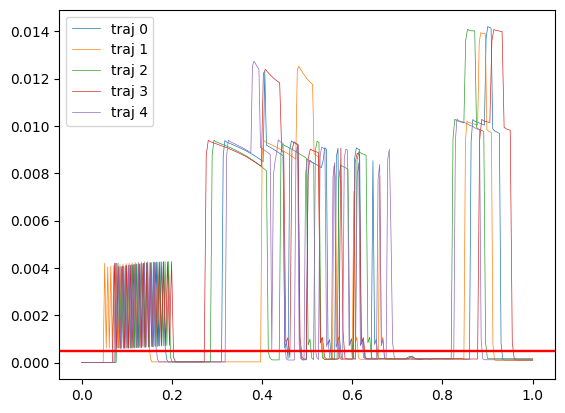

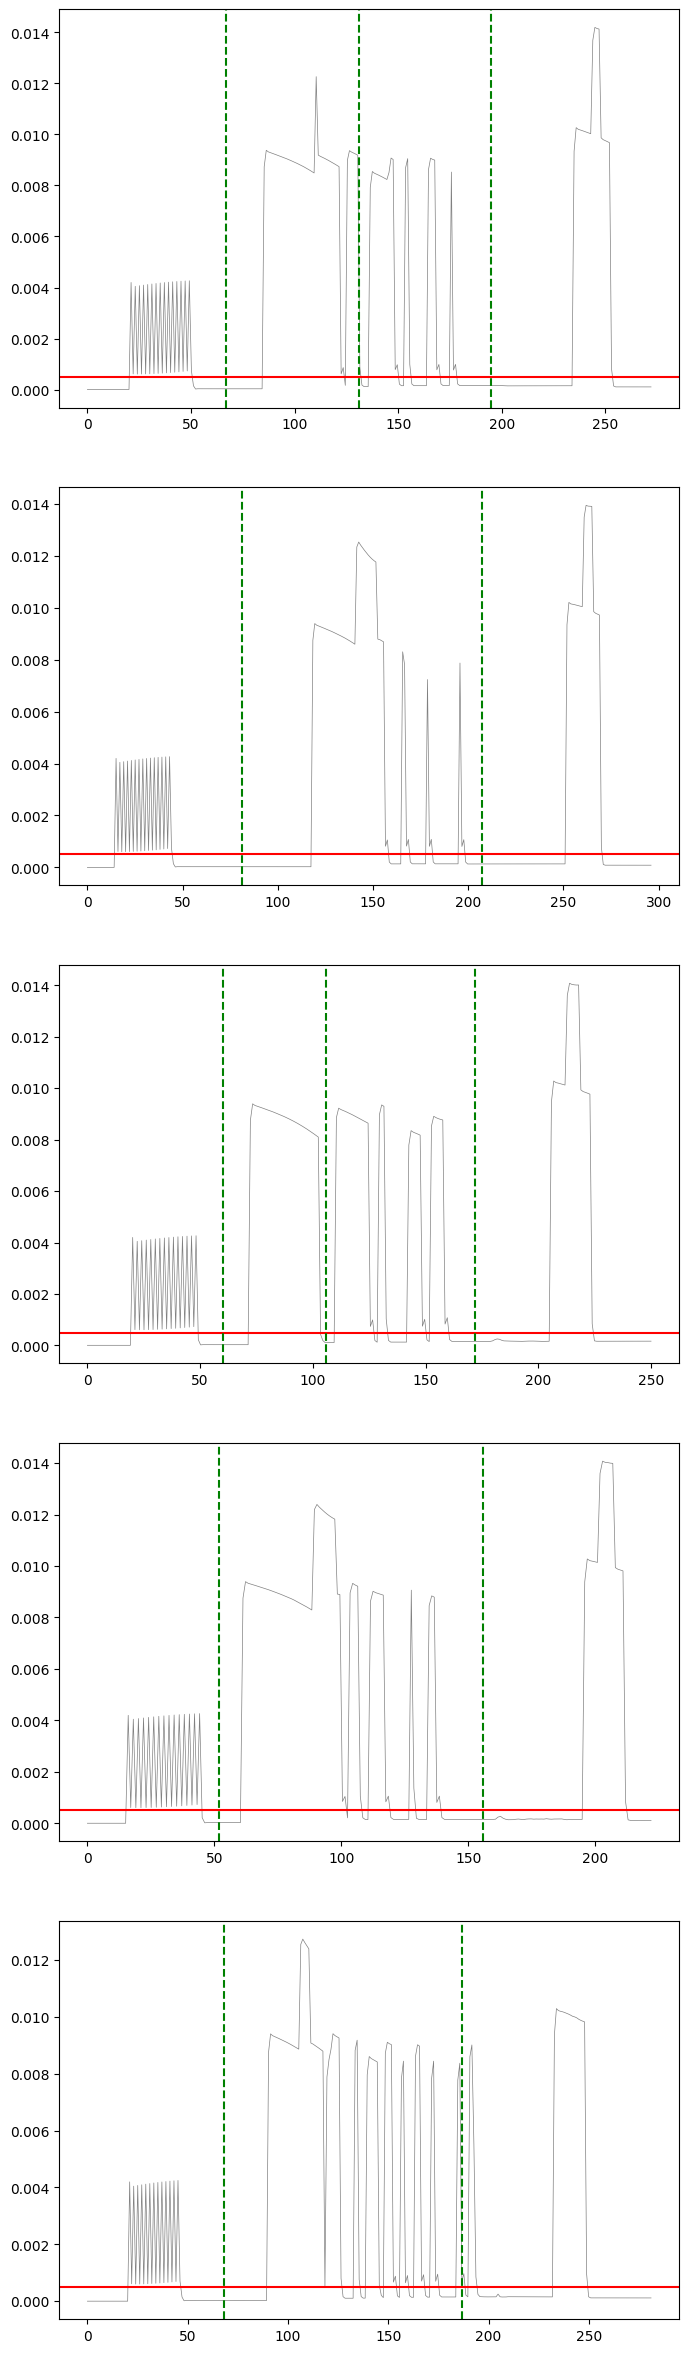

2025-08-03 19:31:07.351 | INFO     |  Creating segement of demos.
2025-08-03 19:31:07.357 | INFO     |  Creating segement of demos.
2025-08-03 19:31:07.366 | INFO     |  Creating segement of demos.
2025-08-03 19:31:07.373 | INFO     |  ... created 3 segments
2025-08-03 19:31:07.374 | INFO     |    Fitting candidate frame 1/10
2025-08-03 19:31:07.374 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:31:07.426 | INFO     |    Fitting candidate frame 2/10
2025-08-03 19:31:07.429 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:31:07.528 | INFO     |    Fitting candidate frame 3/10
2025-08-03 19:31:07.531 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:31:07.658 | INFO     |    Fitting candidate frame 4/10
2025-08-03 19:31:07.661 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:31:07.799 | INFO     |    Fitting candidate frame 5/10
2025-08-03 19:31:07.800 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:31:07.906 | INFO     |    Fitting candidate frame 6/10
2025-08-03 19:31:07.907 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:31:07.950 | INFO     |    Fitting candidate frame 7/10
2025-08-03 19:31:07.951 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:31:07.996 | INFO     |    Fitting candidate frame 8/10
2025-08-03 19:31:07.997 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:31:08.110 | INFO     |    Fitting candidate frame 9/10
2025-08-03 19:31:08.112 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:31:08.182 | INFO     |    Fitting candidate frame 10/10
2025-08-03 19:31:08.184 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:31:08.282 | INFO     |  Creating partial frame view of demos.
2025-08-03 19:31:08.425 | INFO     |    Fitting candidate frame 1/10
2025-08-03 19:31:08.426 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:31:08.480 | INFO     |    Fitting candidate frame 2/10
2025-08-03 19:31:08.481 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:31:08.554 | INFO     |    Fitting candidate frame 3/10
2025-08-03 19:31:08.554 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:31:08.629 | INFO     |    Fitting candidate frame 4/10
2025-08-03 19:31:08.630 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:31:08.696 | INFO     |    Fitting candidate frame 5/10
2025-08-03 19:31:08.697 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:31:08.763 | INFO     |    Fitting candidate frame 6/10
2025-08-03 19:31:08.764 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:31:08.828 | INFO     |    Fitting candidate frame 7/10
2025-08-03 19:31:08.828 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:31:08.909 | INFO     |    Fitting candidate frame 8/10
2025-08-03 19:31:08.910 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:31:08.983 | INFO     |    Fitting candidate frame 9/10
2025-08-03 19:31:08.984 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:31:09.066 | INFO     |    Fitting candidate frame 10/10
2025-08-03 19:31:09.066 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:31:09.143 | INFO     |  Creating partial frame view of demos.
2025-08-03 19:31:09.248 | INFO     |    Fitting candidate frame 1/10
2025-08-03 19:31:09.250 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-03 19:31:09.298 | INFO     |    Fitting candidate frame 2/10
2025-08-03 19:31:09.300 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-03 19:31:09.400 | INFO     |    Fitting candidate frame 3/10
2025-08-03 19:31:09.402 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-03 19:31:09.544 | INFO     |    Fitting candidate frame 4/10
2025-08-03 19:31:09.546 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-03 19:31:09.645 | INFO     |    Fitting candidate frame 5/10
2025-08-03 19:31:09.646 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-03 19:31:09.689 | INFO     |    Fitting candidate frame 6/10
2025-08-03 19:31:09.690 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-03 19:31:09.745 | INFO     |    Fitting candidate frame 7/10
2025-08-03 19:31:09.747 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-03 19:31:09.827 | INFO     |    Fitting candidate frame 8/10
2025-08-03 19:31:09.828 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-03 19:31:09.935 | INFO     |    Fitting candidate frame 9/10
2025-08-03 19:31:09.936 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-03 19:31:09.984 | INFO     |    Fitting candidate frame 10/10
2025-08-03 19:31:09.985 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-03 19:31:10.054 | INFO     |  Creating partial frame view of demos.
2025-08-03 19:31:10.179 | INFO     |  Segmented trajs into 3 segments
2025-08-03 19:31:10.197 | INFO     |  Frame score (abs):
            ee_init    obj000    obj001    obj002    obj003    obj004  \
Segment 0 -0.142831 -0.142831 -0.142831 -0.142831 -0.142831 -0.142831   
Segment 1 -0.142831 -0.142831 -0.142831 -0.142831 -0.142831 -0.142831   
Segment 2 -0.142719 -0.142720 -0.142720 -0.142720 -0.142720 -0.142720   

             obj005    obj006    obj007    obj008  
Segment 0 -0.142831 -0.000208 -0.000005 -0.000021  
Segment 1 -0.142831 -0.000954 -0.000948 -0.110666  
Segment 2 -0.142720 -0.000642 -0.000885 -0.144989  
2025-08-03 19:31:10.208 | INFO     |  Frame score (rel):
            ee_init    obj000    obj001    obj002    obj003    obj004  \
Segment 0  1.000000  0.999999  0.999999  0.999999  0.999999  0.999999   
Segment 1  1.000000  0.999999  0.999999  0.999999  0.999999  0.999999   
Segment 2  0.984348 

Fitting segments:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

((array([[2.01e+28, 2.01e+28, 1.95e+28, 1.83e+28, 1.68e+28, 1.49e+28,
          1.28e+28, 1.07e+28, 8.68e+27, 6.83e+27, 5.22e+27, 3.87e+27,
          2.78e+27, 1.94e+27, 1.32e+27, 8.67e+26, 5.53e+26, 3.43e+26,
          2.06e+26, 1.20e+26, 6.81e+25, 3.32e+25, 1.71e+25, 6.07e+24,
          2.85e+24, 7.32e+23, 3.12e+23, 5.78e+22, 2.23e+22, 2.98e+21,
          1.04e+21, 9.94e+19, 3.13e+19, 2.15e+18, 6.10e+17, 2.98e+16,
          7.62e+15, 2.66e+14, 6.10e+13, 1.52e+12, 3.11e+11, 5.52e+09,
          1.01e+09, 1.28e+07, 2.08e+06, 1.87e+04, 2.72e+03, 1.74e+01,
          4.31e-02, 5.04e-03, 1.33e-03, 2.92e-04, 6.16e-05, 1.26e-05,
          2.51e-06, 4.85e-07, 9.09e-08, 1.65e-08, 2.92e-09, 5.00e-10,
          8.31e-11, 1.34e-11, 2.10e-12, 3.19e-13, 4.71e-14, 2.01e+28,
          2.01e+28, 1.95e+28, 1.83e+28, 1.68e+28, 1.49e+28, 1.28e+28,
          1.07e+28, 8.68e+27, 6.83e+27, 5.22e+27, 3.87e+27, 2.78e+27,
          1.72e+27, 7.72e+26, 4.74e+26, 1.59e+26, 8.88e+25, 2.15e+25,
          3.35e+24, 

In [43]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


2025-08-03 19:31:10.868 | INFO     |  Did not specify time_based, deciding automatically.


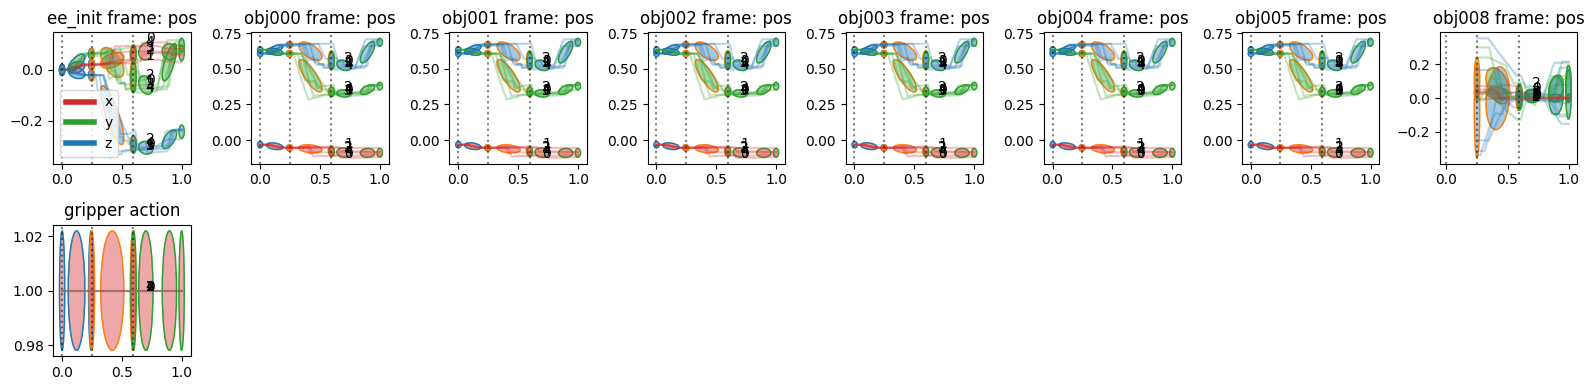

In [44]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=False, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False) #, size=(150, 10))


In [45]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.EM_HMM, ))


2025-08-03 19:31:16.682 | INFO     |  Fitting AutoTPGMM


Fitting segments:   0%|          | 0/3 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

((array([[1.73e-013, 3.11e-014, 4.66e-015, 5.75e-016, 5.74e-017, 4.56e-018,
          2.83e-019, 1.36e-020, 4.93e-022, 1.33e-023, 2.64e-025, 3.78e-027,
          3.84e-029, 2.73e-031, 1.33e-033, 4.38e-036, 9.61e-039, 1.38e-041,
          1.28e-044, 7.49e-048, 2.74e-051, 3.60e-055, 2.54e-059, 5.03e-064,
          4.88e-069, 1.01e-074, 9.22e-081, 1.35e-087, 7.92e-095, 5.50e-103,
          1.39e-111, 3.07e-121, 2.21e-131, 1.02e-142, 1.38e-154, 8.84e-168,
          1.48e-181, 8.54e-197, 1.15e-212, 3.97e-230, 2.84e-248, 3.82e-268,
          9.48e-289, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 1.73e-013,
          3.11e-014, 4.66e-015, 5.75e-016, 5.74e-017, 4.56e-018, 2.83e-019,
          1.36e-020, 4.93e-022, 1.33e-023, 2.64e-025, 3.79e-027, 3.84e-029,
          2.

2025-08-03 19:31:17.828 | INFO     |  Did not specify time_based, deciding automatically.


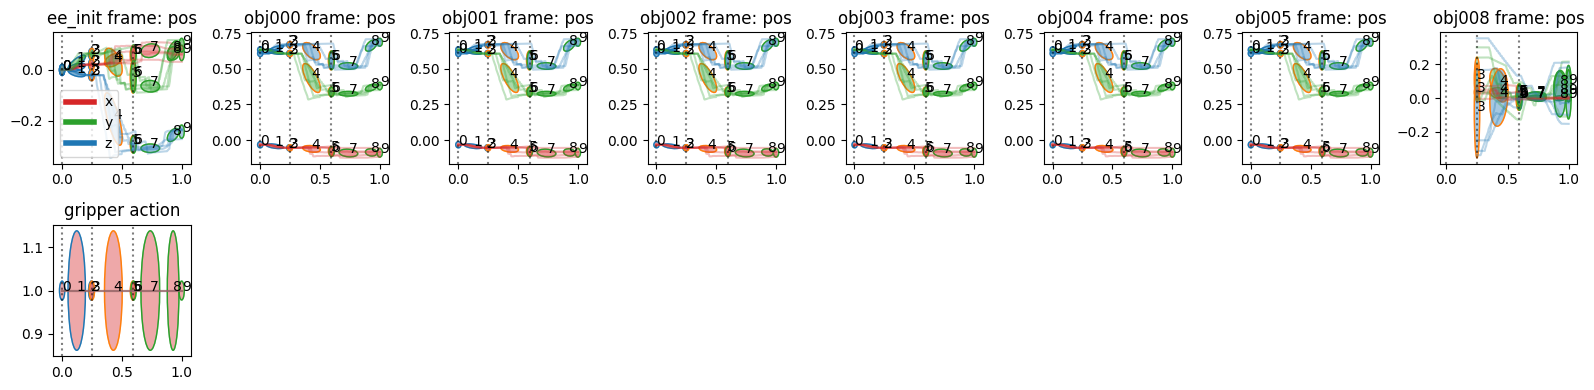

In [46]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False)

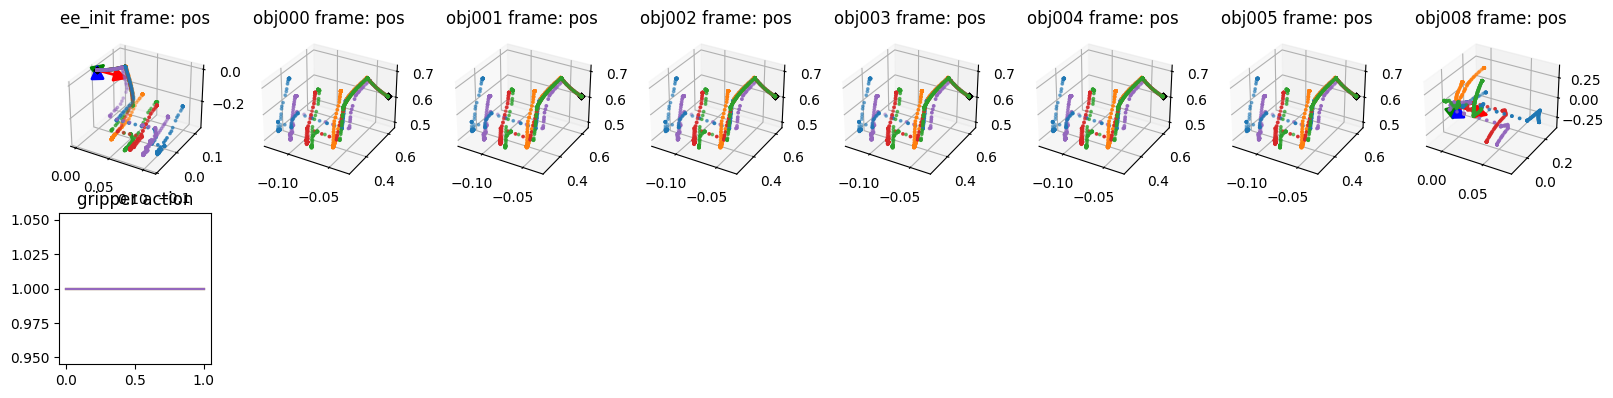

In [47]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False, time_based=False)

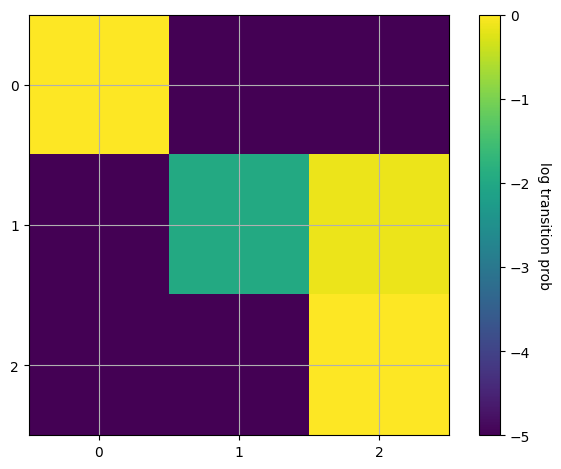

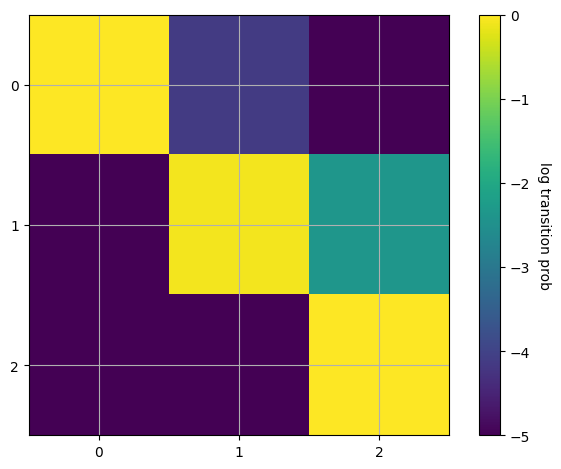

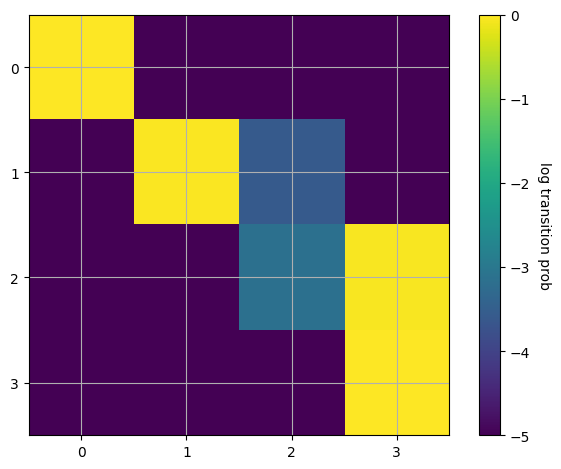

In [48]:
atpgmm.plot_hmm_transition_matrix()

In [49]:
atpgmm.to_disk(data_root / task / 'demos_gmm_policy-release.pt')

In [50]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2025-08-03 19:31:31.354 | INFO     |  Caculated segment transition probabilities: (array([[1.]]), array([[0.98]]))
2025-08-03 19:31:31.355 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-03 19:31:31.768 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-03 19:31:32.002 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

GMR:   0%|          | 0/5 [00:00<?, ?it/s]

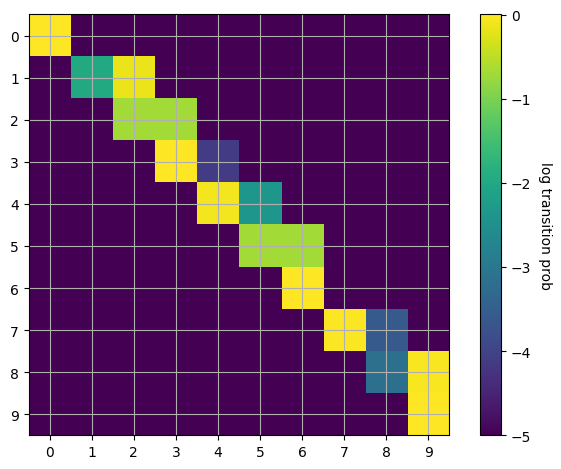

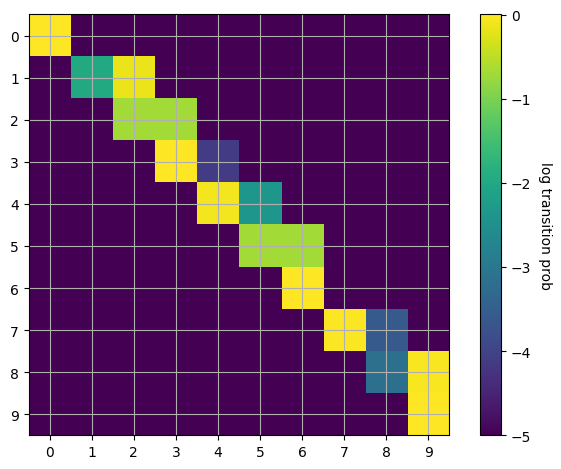

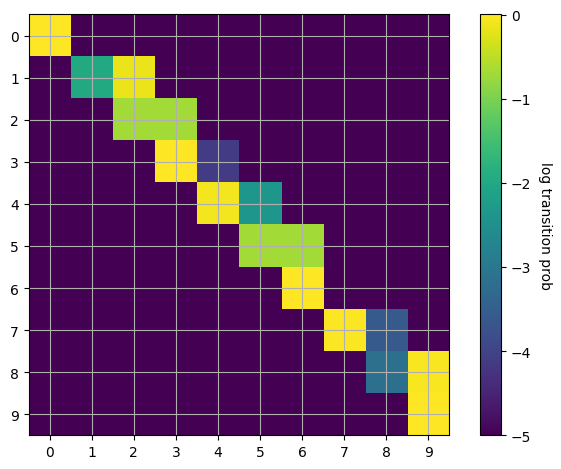

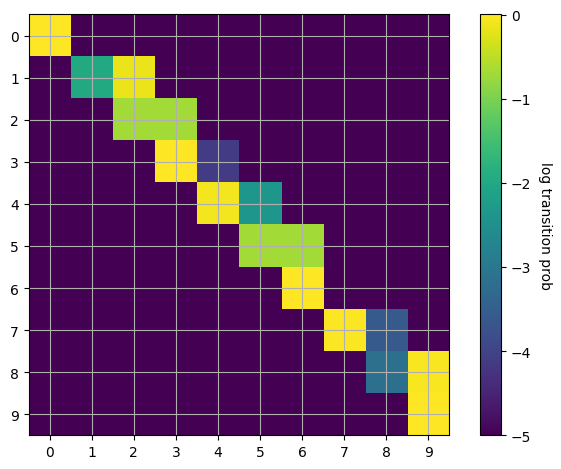

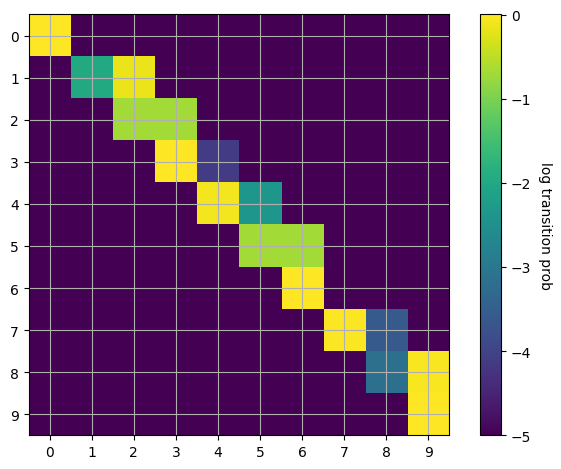

In [51]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)

2025-08-03 19:31:39.266 | INFO     |  Taking frame origins from demos.


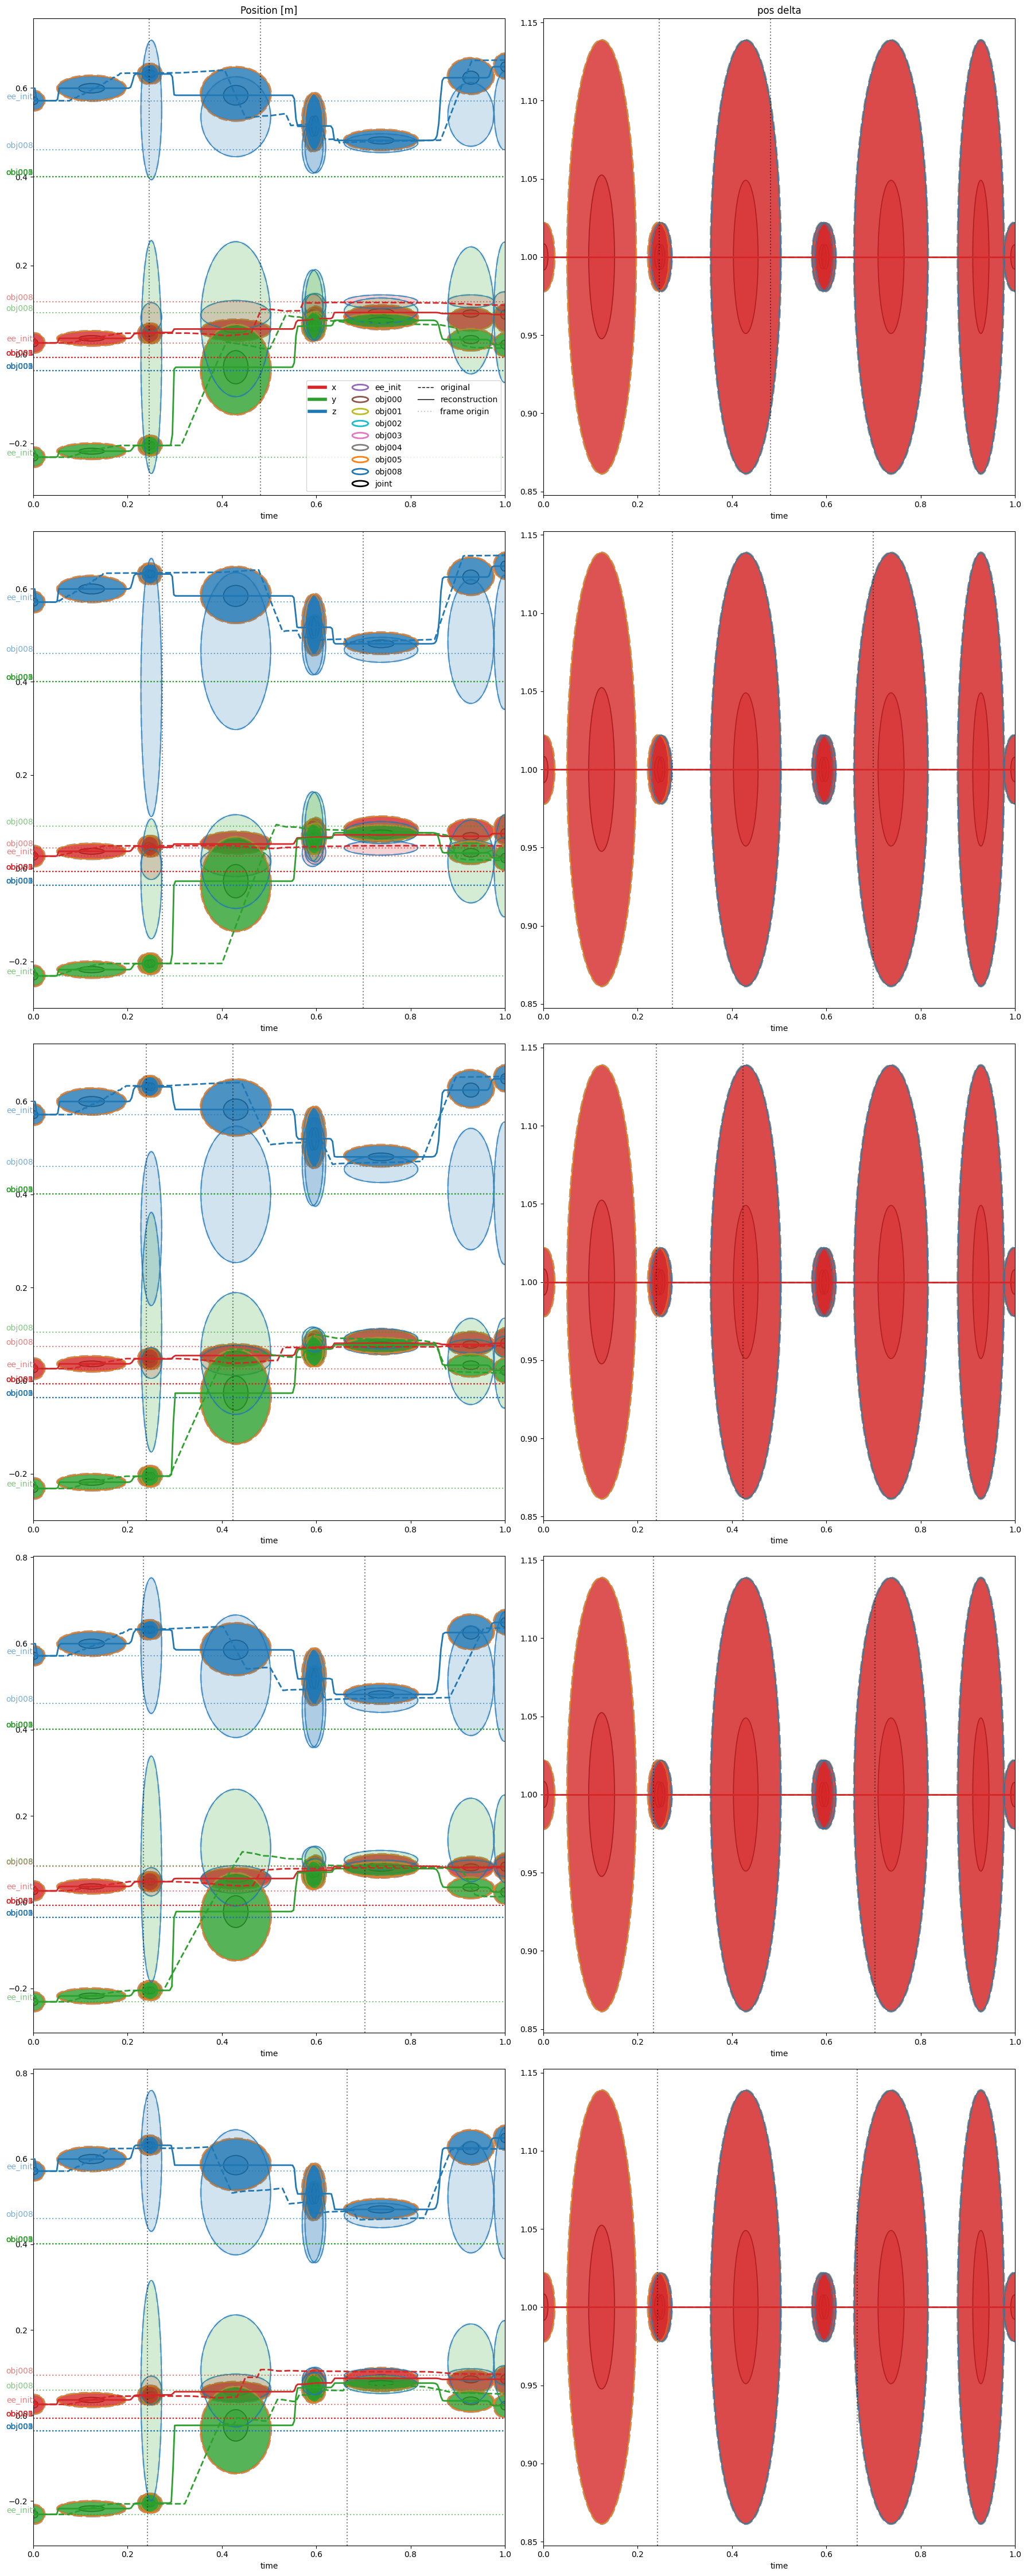

In [52]:

atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=True, equal_aspect=False, per_segment=False)


In [53]:
atpgmm.plot_reconstructions(
    seg_trans_marginals, seg_joint_models, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=False, equal_aspect=True, per_segment=False)


IndexError: tuple index out of range